<a href="https://colab.research.google.com/github/rubygitflow/Sequence-to-Sequence-training-models/blob/master/University_of_Artificial_Intelligence_HomeWork_17_Pro_1_Text_generation_Chat_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 17.Text generation

# **Import библиотек**

In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Парсинг данных**

In [ ]:
######################
# Открываем файл с диалогами
######################
corpus = open('/content/drive/My Drive/Базы/Диалоги(рассказы).yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[200]))

Количество пар вопрос-ответ : 11905
Пример диалога : ['Около сотни...', 'Точнее!']


**2) Учёт в тексте знаков препинания**

In [ ]:
def insert_space(text, index):
  return text[:index] + ' ' + text[index:]

######################
# Парсим текстовую строку - выделяем пункутуацию, 
# сохраняем написание сокращений и действительных чисел
######################
def parsPunctuation(text):
  # преобразование списочного типа данных
  if type(text) == str:        # то передаём переменную  как есть
    out_text = text            
  elif type(text) == list:     # то преобразуем тип данных перед передачей переменной
    out_text = ''
    for elem in text: 
      out_text += ' ' + elem 
  else:                        # иначе обнуляем переменную
    print('Early stop')
    return ""

  # выделение знаков препинания
  out_text = out_text.replace('.-', '. -')

  # обработка графематики "точек"
  len_text = len(out_text)
  if out_text.find('.') > -1:
    text_dot = out_text
    for j in reversed(range(len_text)):
      if out_text[j]=='.':
        # игнорируем инициалы и сокращения
        if not ( (j > 2 and  out_text[j-2]=='.') or \
                (j < (len_text - 2) and out_text[j+2]=='.') or \
                (j > 2 and  out_text[j-2]==' ') or \
                (j > 2 and  out_text[j-3]==' ') ):
          text_dot = insert_space(text_dot, j)
  else:
    text_dot = out_text

  len_text = len(text_dot)
          
  # обработка графематики "запятых"
  if text_dot.find(',') > -1:
    text_comma = text_dot
    for j in reversed(range(len_text)):
      if text_dot[j]==',':
        if not (j < (len_text - 1) and text_dot[j+1].isdigit()): # число через запятую
          if j < (len_text - 1) and not text_dot[j+1] in [" ", "\t"]:
            text_comma = insert_space(text_comma, j+1)
          text_comma = insert_space(text_comma, j)
  else:
    text_comma = text_dot

  # обработка графематики остальных знаков препинания
  text_comma = text_comma.replace('!', ' !')
  text_comma = text_comma.replace('?', ' ?')
  text_comma = text_comma.replace(':', ' :')

  text_comma = text_comma.replace('=', ' = ')
  text_comma = text_comma.replace('/', ' / ')
  text_comma = text_comma.replace('(', ' ( ')
  text_comma = text_comma.replace(')', ' ) ')
  text_comma = text_comma.replace('[', ' [ ')
  text_comma = text_comma.replace(']', ' ] ')
  text_comma = text_comma.replace('{', ' { ')
  text_comma = text_comma.replace('}', ' } ')
  text_comma = text_comma.replace('<', ' < ')
  text_comma = text_comma.replace('>', ' > ')
  text_comma = text_comma.replace('"', ' " ')
  text_comma = text_comma.replace('„', ' „ ')
  text_comma = text_comma.replace('“', ' “ ')
  text_comma = text_comma.replace('«', ' « ')
  text_comma = text_comma.replace('»', ' » ')
  text_comma = text_comma.replace(';', ' ; ')
  text_comma = text_comma.replace('\xa0', '')
  text_comma = text_comma.replace('\x301', '')
  text_comma = text_comma.replace('\u0301', '')
  text_comma = text_comma.replace('\ufeff', '')
            
  text_comma = text_comma.replace('  ', ' ')
  text_comma = text_comma.replace('  ', ' ')

  text_comma = text_comma.strip()      

  return text_comma

In [ ]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for i, con in enumerate(conversations): # для каждой пары вопрос-ответ
  if i > 7000: # РЕШАЕМ ПРОБЛЕМУ НЕХВАТКИ ПАМЯТИ НА КОЛЛАБЕ
    break
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(parsPunctuation(con[0])) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(parsPunctuation(con[0])) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(parsPunctuation(answers[i])) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни. ..
Ответ : <START> Точнее ! <END>


**1.1) Разрешить обработку unknown слов**

In [ ]:
######################
# Подключаем токенизатор от keras и собираем словарь индексов
######################
tokenizer = Tokenizer(filters='<>', oov_token='unknown')
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('unknown', 1), ('start', 2), ('end', 3), ('.', 4), ('?', 5), (',', 6), ('!', 7), ('не', 8), ('что', 9), ('а', 10), ('ты', 11), ('я', 12), ('..', 13), ('это', 14), ('в', 15), ('как', 16), ('да', 17), ('и', 18), ('нет', 19), ('вы', 20), ('ну', 21), ('на', 22), ('с', 23), ('же', 24), ('так', 25), ('у', 26), ('где', 27), ('кто', 28), ('он', 29), ('-', 30), ('все', 31), ('тебя', 32), ('мне', 33), ('мы', 34), ('"', 35), ('меня', 36), ('почему', 37), ('куда', 38), ('есть', 39), ('там', 40), ('вот', 41), ('тебе', 42), ('за', 43), ('еще', 44), ('ничего', 45), ('здесь', 46), ('знаю', 47), ('его', 48), ('вас', 49), ('ли', 50)]
Размер словаря : 11012


# **Подготовка выборки**

In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Какая же мораль ?
Пример кодированного вопроса на вход : [ 179   24 3895    5    0    0    0    0    0    0    0    0    0    0
    0]
Размеры закодированного массива вопросов на вход : (6998, 15)
Установленная длина вопросов на вход : 15


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой . Так просто вспомнилось . <END>
Пример раскодированного ответа на вход : [   2  707    4   25  107 7521    4    3    0    0    0    0    0    0
    0    0    0]
Размеры раскодированного массива ответов на вход : (6998, 17)
Установленная длина ответов на вход : 17


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][1][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [   2  707    4   25  107 7521    4    3    0    0    0    0    0    0
    0    0    0]
Пример раскодированного ответа на выход : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (6998, 17, 11012)
Установленная длина вопросов на выход : 17


# **Параметры нейросети и модель обучения**

In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    2202400     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 200)    2202400     input_12[0][0]                   
____________________________________________________________________________________________

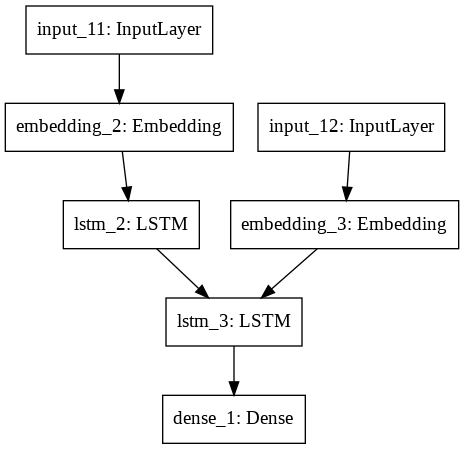

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=30) 
model.save( '/content/drive/My Drive/tmp/model_30epochs(rms).h5' )

Epoch 1/30
140/140 [==============================] - 6s 44ms/step - loss: 2.0562
Epoch 2/30
140/140 [==============================] - 6s 45ms/step - loss: 1.7016
Epoch 3/30
140/140 [==============================] - 6s 45ms/step - loss: 1.6280
Epoch 4/30
140/140 [==============================] - 6s 45ms/step - loss: 1.5733
Epoch 5/30
140/140 [==============================] - 6s 45ms/step - loss: 1.5321
Epoch 6/30
140/140 [==============================] - 6s 44ms/step - loss: 1.4954
Epoch 7/30
140/140 [==============================] - 6s 45ms/step - loss: 1.4599
Epoch 8/30
140/140 [==============================] - 6s 44ms/step - loss: 1.4258
Epoch 9/30
140/140 [==============================] - 6s 44ms/step - loss: 1.3918
Epoch 10/30
140/140 [==============================] - 6s 45ms/step - loss: 1.3592
Epoch 11/30
140/140 [==============================] - 6s 45ms/step - loss: 1.3263
Epoch 12/30
140/140 [==============================] - 6s 44ms/step - loss: 1.2944
Epoch 13/30
1

# **Подготовка и запуск рабочей нейросети с генерацией ответов**

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

**1.2) Разрешить обработку unknown слов**

In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  checkIndex = tokenizer.texts_to_sequences([sentence]) # получаем индексы для каждого слова
  words = parsPunctuation(sentence).lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for index in range(len(checkIndex[0])): # проходимся по длине списка индексов
    if checkIndex[0][index]!=1: # если слово не unknown (имеет индекс 1)
      try:
        tokensList.append(tokenizer.word_index[words[index]]) # определяем токенизатором индекс и добавляем в список
      except Exception:
        print('Что-то пошло не так, раз. Здесь нужно подумать над алгоритмом')

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  try:
    statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  except Exception:
    print('Что-то пошло не так, два. Здесь нужно подумать над алгоритмом')
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation) # выводим ответ сгенерированный декодером

Задайте вопрос : Привет, машина.
Что-то пошло не так, два. Здесь нужно подумать над алгоритмом
 ! end
Задайте вопрос : Привет машина.
 , товарищ генерал . end
Задайте вопрос : Работа зовёт, как думаешь?
 , товарищ генерал . end
Задайте вопрос : машина
 , товарищ командир . end
Задайте вопрос : А меня знаешь как зовут?
 . end
Задайте вопрос : Так и будешь молчать?
 и не знаю . end


# **Загрузка и запуск предобученной модели**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Подгружаем модель из файла и выведем её параметры
model = load_model('/content/gdrive/My Drive/Предобученные сети/model_chatbot_100epochs(rms)+50(ada).h5')
#model = load_model('model_chatbot_100epochs(rms)+50(ada) (1).h5')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    3020800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    3020800     input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
######################
# Устанавливаем связи между слоями рабочей модели и предобученной
######################
def loadInferenceModels():
  encoderInputs = model.input[0]   # входом энкодера рабочей модели будет первый инпут предобученной модели(input_1)
  encoderEmbedding = model.layers[2] # связываем эмбединг слои(model.layers[2] это embedding_1)
  encoderOutputs, state_h_enc, state_c_enc = model.layers[4].output # вытягиваем аутпуты из первого LSTM слоя обуч.модели и даем энкодеру(lstm_1)
  encoderStates = [state_h_enc, state_c_enc] # ложим забранные состояния в состояния энкодера
  encoderModel = Model(encoderInputs, encoderStates) # формируем модель

  decoderInputs = model.input[1]   # входом декодера рабочей модели будет второй инпут предобученной модели(input_2)
  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  decoderEmbedding = model.layers[3] # связываем эмбединг слои(model.layers[3] это embedding_2)
  decoderLSTM = model.layers[5] # связываем LSTM слои(model.layers[5] это lstm_2)
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding.output, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния

  decoderDense = model.layers[6] # связываем полносвязные слои(model.layers[6] это dense_1)
  decoderOutputs = decoderDense(decoderOutputs) # выход с LSTM мы пропустим через полносвязный слой с софтмаксом

    # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
    # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel , decoderModel

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем рабочую модель над предобученной
######################

encModel , decModel = loadInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation) # выводим ответ сгенерированный декодером

Задайте вопрос : ты кто 
 наш вид известен как люди end
Задайте вопрос : скажи что нибудь 
 а что надо говорить end
Задайте вопрос : какой сегодня день
 четверг end
Задайте вопрос : сколько времени
 без пяти пять end
Задайте вопрос : как настроение
 но так то и не знаю end
Задайте вопрос : что то случилось
 о end


# **Глоссарий**
-  Seq2Seq - sequence-to-sequence модель, состоит из двух рекуррентных нейронных сетей (RNN): 

encoder (кодер), которая обрабатывает входные данные,

decoder (декодер), которая генерирует данные вывода.
- Yaml - удобный текстовый формат, позволяющий хранить структурированные данные в иерархии. https://ru.bmstu.wiki/YAML
yaml.safe_load - безопасный метод загрузки данных из файлов, предотвращающий возможность запуска произвольного кода для файлов из ненадежных источников





